# Transfer learning
https://keras.io/guides/transfer_learning/

Transfer learing is when ...

In [122]:
# setup
import numpy as np
import tensorflow as tf
from tensorflow import keras


instantiate base model with pre trained weights
explain xception

In [123]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


freeze base model
to do: explain this more

In [124]:
base_model.trainable = False


create new model on top

to do: explain

In [135]:
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs, outputs)



get dataset

In [126]:
batch_size = 32
img_height = 480
img_width = 640

In [127]:
train_ds = keras.utils.image_dataset_from_directory(
  "ordered_data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
  "ordered_data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 6627 files belonging to 3 classes.
Using 5302 files for training.
Found 6627 files belonging to 3 classes.
Using 1325 files for validation.


In [128]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2']


resize images

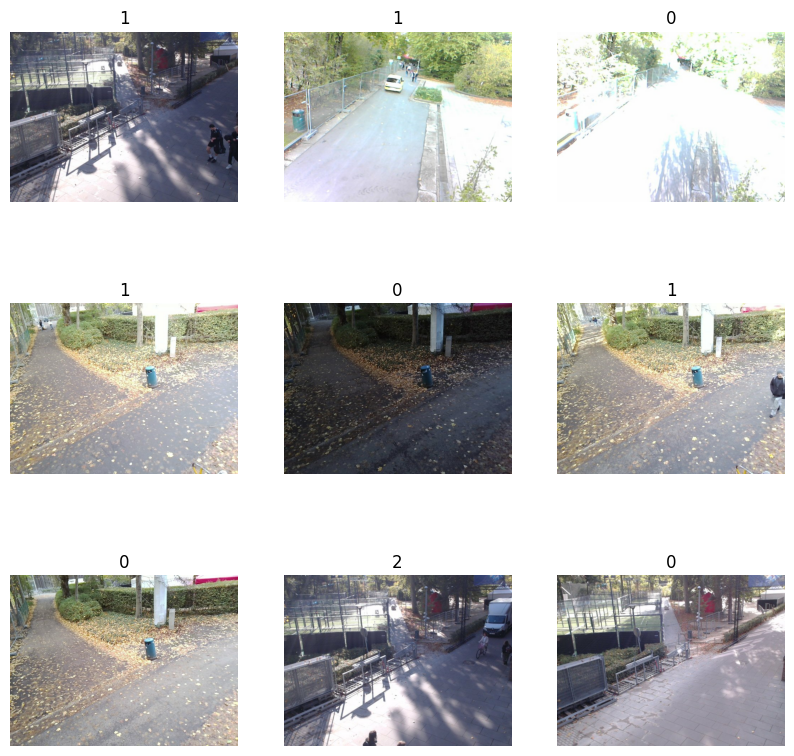

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image[i].numpy().astype("uint8")))
    
    plt.title(np.squeeze(label[i].numpy().astype("uint8")))
    plt.axis("off")
plt.show()

In [130]:
# resize images
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))

train model on new data

In [139]:
# map dataset to correct format
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, 3)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, 3)))

new_dataset = train_ds
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])


In [140]:
print(train_ds)

<MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [141]:
model.fit(new_dataset, epochs=2, validation_data=val_ds, callbacks=[keras.callbacks.EarlyStopping(patience=2)])


Epoch 1/2


C:\Users\astri\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


166/166 [==============================] - 132s 774ms/step - loss: 2.6633 - categorical_accuracy: 0.4966 - val_loss: 1.6333 - val_categorical_accuracy: 0.5668
Epoch 2/2
166/166 [==============================] - 128s 764ms/step - loss: 1.7873 - categorical_accuracy: 0.5400 - val_loss: 2.2275 - val_categorical_accuracy: 0.4158


test/evaluate

In [142]:
# use val dataset to test for now
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

42/42 - 25s - loss: 2.2275 - categorical_accuracy: 0.4158 - 25s/epoch - 596ms/step
Test accuracy: 0.41584905982017517
Test loss: 2.2275376319885254


In [143]:
test_predictions = model.predict(val_ds)
print(test_predictions.shape)
print(test_predictions[0:10])

42/42 [==============================] - 26s 571ms/step
(1325, 3)
[[1.05016366e-01 2.13815346e-01 6.81168318e-01]
 [1.42158970e-01 7.04166293e-01 1.53674692e-01]
 [2.20890176e-02 6.57242775e-01 3.20668161e-01]
 [1.70336698e-05 3.93915176e-03 9.96043801e-01]
 [1.44091481e-03 9.50392277e-04 9.97608662e-01]
 [2.43571624e-01 2.04823744e-02 7.35946059e-01]
 [6.80962112e-05 8.50387275e-01 1.49544597e-01]
 [1.37927188e-02 5.59606105e-02 9.30246651e-01]
 [1.15478797e-04 9.41127360e-01 5.87572195e-02]
 [3.98587035e-05 1.16952667e-02 9.88264918e-01]]


In [148]:
predicted_labels = np.argmax(test_predictions, axis=1)
print(predicted_labels.shape)

(1325,)


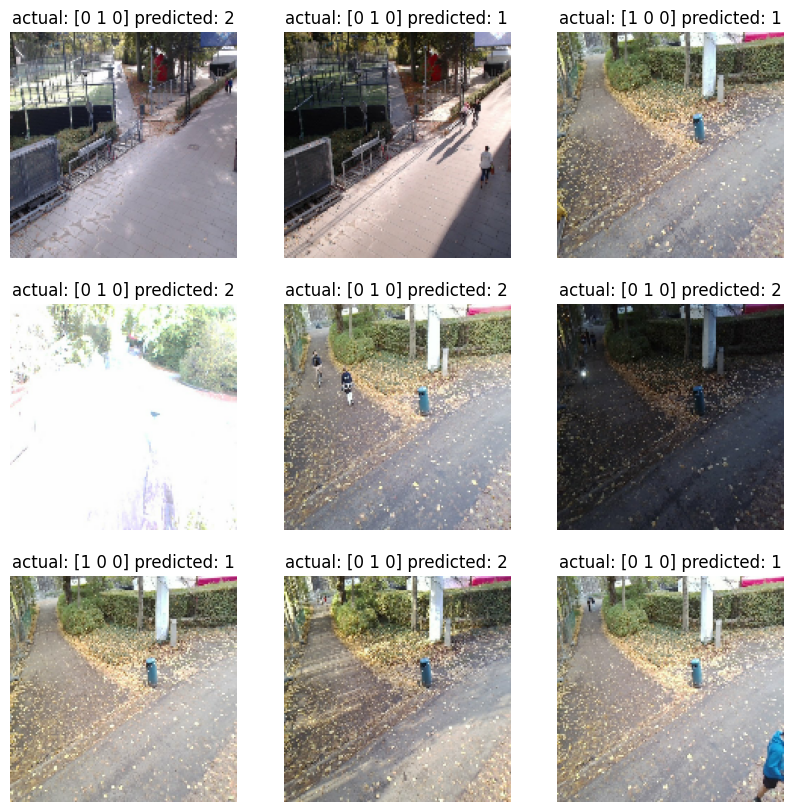

In [149]:

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(image[i].numpy().astype("uint8")))
    
    plt.title('actual: ' + str(np.squeeze(label[i].numpy().astype("uint8"))) + ' predicted: ' + str(predicted_labels[i]))
    plt.axis("off")
plt.show()

model summary

In [147]:

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
